# Anomaly Screening Applying Pseudo-wells (ASAP)

Stavanger Machine Learning Hackathon 18-19 September, 2018.

Project page: <https://events.agilescientific.com/project/asap>

## Pseudowell creation

This notebook shows how to:

* read well data;
* simplify elastic logs by "blocking" (i.e., replacing the natural, high-frequency variations of the recorded logs, with a constant value averaged over certain intervals of interest);
* create pseudo-logs by modifying blocked logs within reservoir section to simulate different conditions of fluid content, porosity and thickness following a given rock physics model;
* creating near and far-offset synthetic seismograms using as inputs the above pseudo-logs;
* output synthetic seismograms to be fed into notebook #2 (seismic data analysis via ML).

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import bruges as b
import hackathon2018_library as hl
%config InlineBackend.figure_format = 'retina'

We first read in well data from Per Avseth's [open dataset distributed with the first edition of QSI (Quantitative Seismic Interpretation)](https://srb.stanford.edu/quantitative-seismic-interpretation).

Well 2 corresponds to the Glitne well 15/5-5 drilled in 1995. Well 5 is 15/5-6 (1997) and well 3 is 15/5-3. For all the informations related to these wells check [NPD's Factpages](http://factpages.npd.no/factpages/).

In [11]:
w2=pd.read_csv('qsiwell2.csv', index_col=0)
w3=pd.read_csv('qsiwell3.csv', index_col=0)
w4=pd.read_csv('qsiwell4.csv', index_col=0)
w5=pd.read_csv('qsiwell5.csv', index_col=0)

wells=    [ w2,       w3,       w5]
names=     ['15/5-5','15/5-3', '15/5-6']

Build a simple Pandas dataframe with the most relevant stratigraphic markers (Lista Fm. is the caprock shale and Heimdal Fm. is the reservoir sand):

In [15]:
tops_w2={'Lista': 2127, 'Heimdal': 2154}
tops_w3={'Lista': 2153, 'Heimdal': 2180}
tops_w5={'Lista': 2145, 'Heimdal': 2172}
tops=pd.DataFrame()
for i,val in enumerate([tops_w2,tops_w3,tops_w5]):
    tempdf=pd.DataFrame.from_dict(val, orient='index')
    tempdf.columns=[names[i]]
    tops=pd.concat([tops, tempdf],axis=1)

Summary plot of most relevant logs plus stratigraphic markers:

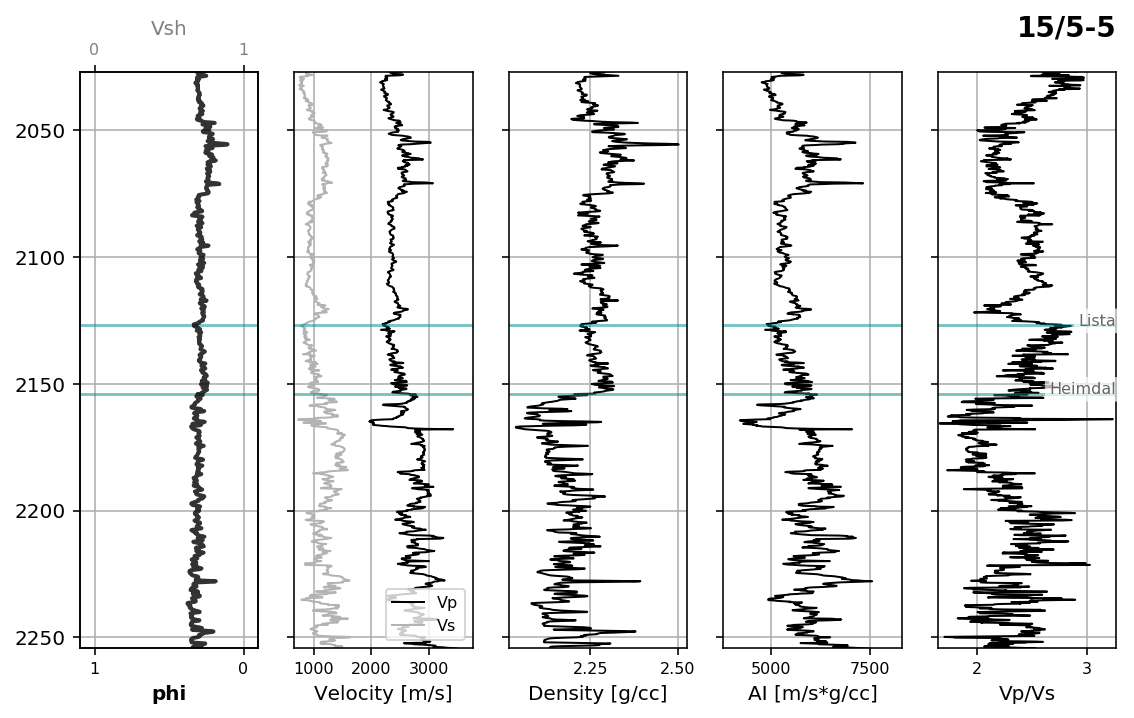

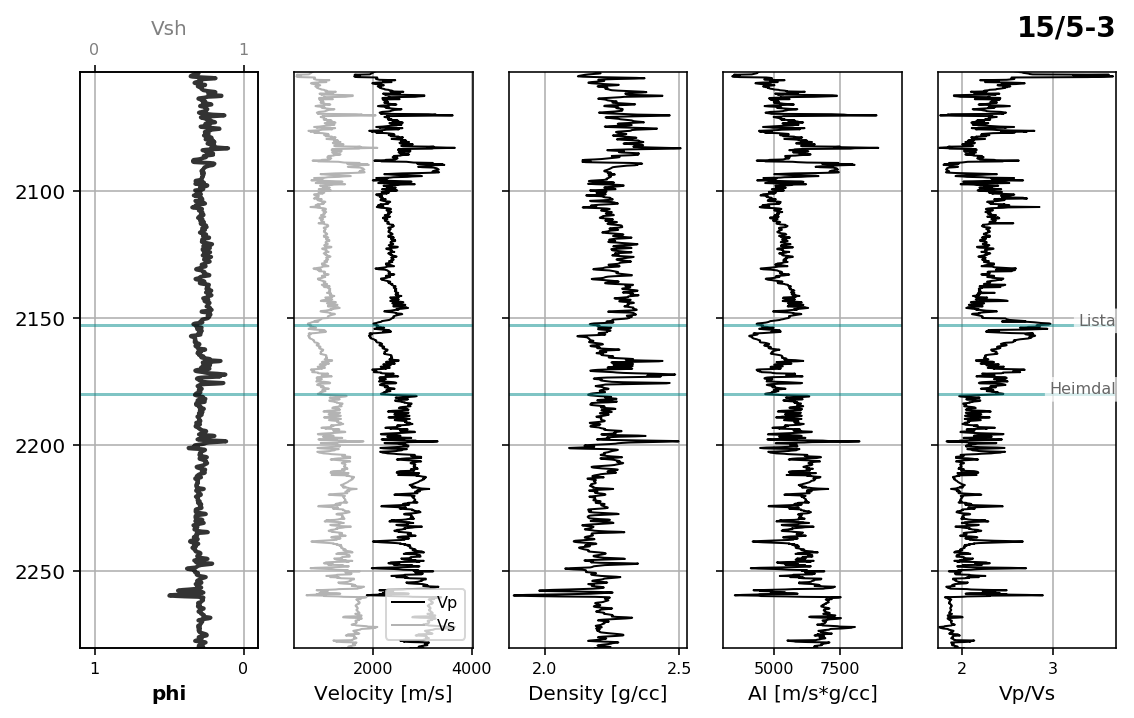

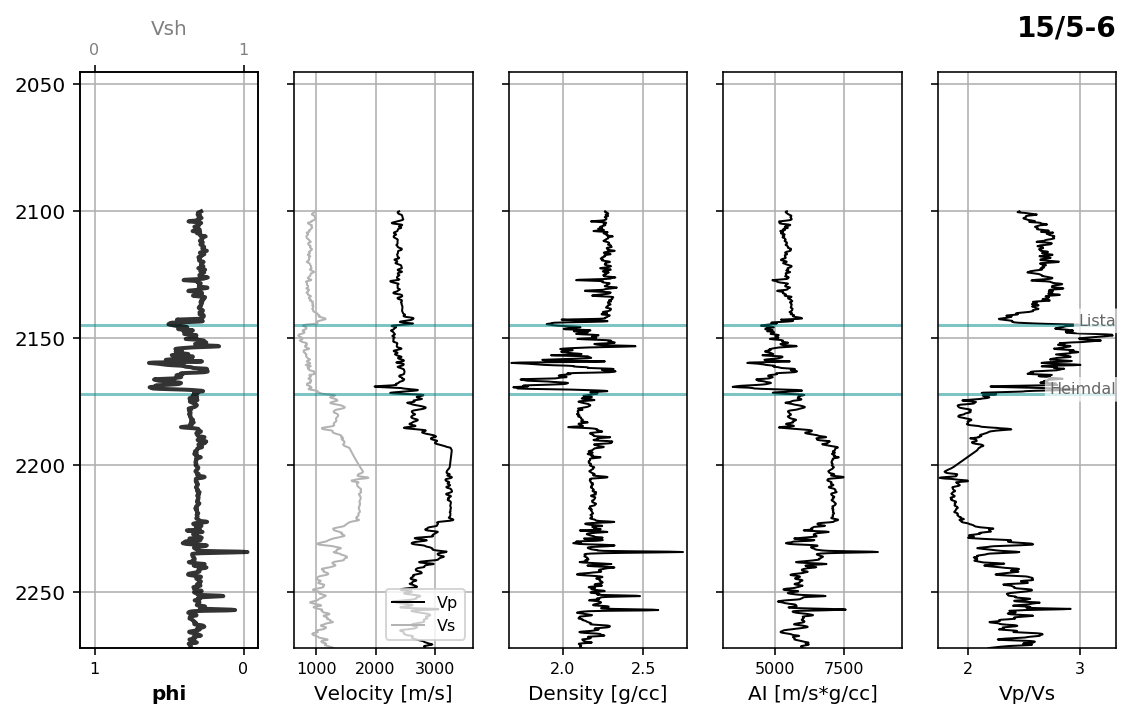

In [20]:
for i,p in enumerate(wells):
    z1 = tops[names[i]]['Lista']-100
    z2 = tops[names[i]]['Heimdal']+100
    hl.quicklook(p,ztop=z1,zbot=z2,name=names[i],tops=tops[names[i]])
#     plt.savefig('FIGS/{}_original_wells.png'.format(names[i].replace('/','_')))

define forward modeling parameters:

* sample rate: 4 ms
* wavelet: Ricker 30 Hz
* angle range: 5 and 30 degrees to simulate Near and Far traces

In [69]:
dt=.004
wavl=b.filters.ricker(.25, dt, 30)
ang=np.linspace(5,30,2)

Calculate simple time-depth tables from sonic measurements with function `td`, then we store into `topres_<well>` the top Heimdal converted to two-way-times.

In [70]:
tdr_w2=hl.td(w2,KB=26,WD=109)
topres_w2=hl.get_twt(tdr_w2,tops['15/5-5']['Heimdal'])

tdr_w3=hl.td(w3,KB=26,WD=109)
topres_w3=hl.get_twt(tdr_w2,tops['15/5-3']['Heimdal'])

tdr_w5=hl.td(w5,KB=26,WD=109)
topres_w5=hl.get_twt(tdr_w5,tops['15/5-6']['Heimdal'])

[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 2013.253 [m] = 2.495 [s]
[TD] computed twt scale range: 2.495-2.926 [s]
[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 200.150 [m] = 0.229 [s]
[TD] computed twt scale range: 0.229-3.625 [s]
[TD] water bottom two-way-time: 0.147 [s]
[TD] sonic log start: 2100.072 [m] = 2.604 [s]
[TD] computed twt scale range: 2.604-2.754 [s]


***

Read in pseudowells (_files created in Anders' script, to be merged in this notebook_), converts them to two-way-time, create synthetic seismograms and output to Pandas dataframe:

Notes: the function `make_synt` will compute as many traces as they are defined in the array `ang` so ideally we can compute full-offset seismograms but for simplicity we just create two traces.

**START ANDERS CODE**

In [1]:
# # -*- coding: utf-8 -*-
# """
# Created on Tue Sep 18 10:35:05 2018

# @author: ANDD
# """

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
import scipy.io as sio
# import matplotlib 
# #%matplotlib qt
# font = {'family' : 'normal',
#         'weight' : 'bold',
#         'size'   : 22}

matplotlib.rc('font', **font)

Wnam = '15_5_5';top_blocks = [2050,2154, 2200,2245]
#Wnam = '155_6';top_blocks = [2056,2160, 2222,2267]
#Wnam = '155_3';top_blocks = [2076,2180, 2240,2285]
infile = Wnam + '.mat'
Wdict = sio.loadmat(infile)

In [1]:
# -*- coding: utf-8 -*-
# """
# Created on Tue Sep 18 10:35:05 2018

# @author: ANDD
# """

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
keys = ['Md','Vp_b', 'Vs_b', 'Rhob_b', 'porosity', 'Vsh', 'Vp_o', 'Vs_o', 'Rhob_o']
cleaned_wdict = {key: Wdict[key].ravel() for key in keys}
df_in = pd.DataFrame.from_dict(cleaned_wdict)
df_in = df_in.dropna()

Md = df_in.Md

Wdict=df_in

In [1]:
def indices(a, func):
    return [i for (i, val) in enumerate(a) if func(val)]
  
def logplot(Vsh,Md,Vp,Vs,Rho,MD,Vp_out,Vs_out,Rho_out):   
    plt.figure(figsize = (20,10))
    plt.subplot(1,4,1)
    plt.plot(Vsh,Md)
    plt.ylim(np.max(MD)+2,np.min(MD)-2)
    plt.xlabel('Vsh (fraction)')
    plt.ylabel('Measured depth (m)')
    
    plt.subplot(1,4,2)
    plt.plot(Vp,Md)
    plt.plot(Vp_out,MD, color = 'red',linewidth=4.0 )
    plt.ylim(np.max(MD)+2,np.min(MD)-2)
    plt.xlabel('Vp (m/s)')
    plt.gca().set_yticks([])
    
    plt.subplot(1,4,3)
    plt.plot(Vs,Md)
    plt.plot(Vs_out,MD, color = 'red' ,linewidth=4.0)
    plt.ylim(np.max(MD)+2,np.min(MD)-2)
    plt.xlabel('Vs (m/s)')
    plt.gca().set_yticks([])
    
    plt.subplot(1,4,4)
    plt.plot(Rho,Md)
    plt.plot(Rho_out,MD, color = 'red',linewidth=4.0 )
    plt.ylim(np.max(MD)+2,np.min(MD)-2)
    plt.xlabel('Density (g/ccm)')
    plt.gca().set_yticks([])
 

In [1]:
   
def generate_wells(Wdict,top_blocks,Wnam):
    
    Vp = Wdict['Vp_b'].ravel();
    Vs = Wdict['Vs_b'].ravel()
    Rho = Wdict['Rhob_b'].ravel()
    Por = Wdict['porosity'].ravel()
    Vsh = Wdict['Vsh'].ravel()
    Md = Wdict['Md'].ravel()
    Vp_o = Wdict['Vp_o'].ravel()
    Vs_o = Wdict['Vs_o'].ravel()
    Rho_o = Wdict['Rhob_o'].ravel()

    Vp_bl = np.zeros(np.size(Vp))
    Vs_bl=np.zeros(np.size(Vp))
    Rho_bl = np.zeros(np.size(Vp))
    
    
    Vp_const = np.zeros((np.shape(top_blocks)))
    Vs_const = np.zeros(np.shape(top_blocks))
    Rho_const = np.zeros(np.shape(top_blocks))
    Por_const = np.zeros(np.shape(top_blocks))
    
    Vp_const_o = np.zeros((np.shape(top_blocks)))
    Vs_const_o = np.zeros(np.shape(top_blocks))
    Rho_const_o = np.zeros(np.shape(top_blocks))
    
    for ii, top in enumerate(top_blocks):
        if ii== len(top_blocks)-1:
            continue
        ind = indices(Md, lambda x: x>= top_blocks[ii] and x< top_blocks[ii+1])
        Vp_bl[ind] = np.mean(Vp[ind])
        Vs_bl[ind] = np.mean(Vs[ind])
        Rho_bl[ind] = np.mean(Rho[ind])
       
        Vp_const[ii]=np.mean(Vp[ind]) 
        Vs_const[ii]=np.mean(Vs[ind]) 
        Rho_const[ii]=np.mean(Rho[ind])
        Por_const[ii]=np.mean(Por[ind])
        
        Vp_const_o[ii]=np.mean(Vp_o[ind]) 
        Vs_const_o[ii]=np.mean(Vs_o[ind]) 
        Rho_const_o[ii]=np.mean(Rho_o[ind]) 
        
        
    
    

        
    d = {'Depth':Md, 'Vp': Vp_bl, 'Vs': Vs_bl, 'Rho': Rho_bl}
    df = pd.DataFrame(data=d)
    df2 = df[(df.Depth>=top_blocks[0]) & (df.Depth<=top_blocks[3])]
#    df2.to_csv('W15_5_5')
    
    Z= np.linspace(0,60,4)
    Sw= np.linspace(0,1,5)
    dPor = [-.1, -.05, 0, .05]
    MD = df2.Depth.ravel()
     
    ind_top = indices(MD, lambda x: x>= top_blocks[0] and x<= top_blocks[1])
    for jj in Z:
        Vp_z = np.ones(np.shape(MD))*Vp_const[2]
        Vs_z = np.ones(np.shape(MD))*Vs_const[2]
        Rho_z = np.ones(np.shape(MD))*Rho_const[2]
        
        Vp_z_o = np.ones(np.shape(MD))*Vp_const_o[2]
        Vs_z_o = np.ones(np.shape(MD))*Vs_const_o[2]
        Rho_z_o = np.ones(np.shape(MD))*Rho_const_o[2]
        
        ind_base = indices(MD, lambda x: x> top_blocks[1] and x< top_blocks[1]+jj)
        Vp_z[ind_top]=Vp_const[0];Vp_z[ind_base]=Vp_const[1]
        Vs_z[ind_top]=Vs_const[0];Vs_z[ind_base]=Vs_const[1]
        Rho_z[ind_top]=Rho_const[0];Rho_z[ind_base]=Rho_const[1]
        
        Vp_z_o[ind_top]=Vp_const_o[0];Vp_z_o[ind_base]=Vp_const_o[1]
        Vs_z_o[ind_top]=Vs_const_o[0];Vs_z_o[ind_base]=Vs_const_o[1]
        Rho_z_o[ind_top]=Rho_const_o[0];Rho_z_o[ind_base]=Rho_const_o[1]
        
        
        
        for kk in Sw:
            Vp_sw = kk*Vp_z + (1-kk)*Vp_z_o
            Vs_sw = kk*Vs_z + (1-kk)*Vs_z_o
            Rho_sw = kk*Rho_z + (1-kk)*Rho_z_o
            
            
            for pp in dPor:
                dVp_br = -pp*4500
                dVp_o = -pp*4500
                dVs_br = -pp*3100
                dVs_o = -pp*3050
                dVs = kk*dVs_br + (1-kk)*dVs_o
                dVp = kk*dVp_br + (1-kk)*dVp_o
                
                dRho_br = (2.65 - 1)*-pp
                dRho_o  = (2.65 -0.8)*-pp
                dRho = kk*dRho_br + (1-kk)*dRho_o
                
                #Vp_out=Vp_sw; Vs_out=Vs_sw; Rho_out=Rho_sw; 
                Vp_out=np.copy(Vp_sw); Vs_out=np.copy(Vs_sw); Rho_out=np.copy(Rho_sw);
                Vp_out[ind_base] = Vp_sw[ind_base] + dVp
                Vs_out[ind_base] = Vs_sw[ind_base] + dVs
                Rho_out[ind_base] = Rho_sw[ind_base] + dRho
               
#                if jj==60 and kk==1 and pp>0:
#                    print(Rho_out.shape, MD.shape, Rho_sw.shape)
#                    print('dRho is: ' +str(dRho),' and dPor is:  ',str(pp))
#                    logplot(Vsh,Md,Vp,Vs,Rho,MD,Vp_out,Vs_out,Rho_out)
            
                d_out = {'Depth':MD, 'Vp': Vp_out, 'Vs': Vs_out, 'Rho': Rho_out}
                df_out = pd.DataFrame(data=d_out)
#                name = Wnam + '_Z' + str(int(np.round(jj))) + '_Sw' + str(int(100*kk)) + '_Por' + str(int((0.3+pp)*100))
                name = 'W{:s}_Z{:02d}_Sw{:03d}_Por{:02d}'.format(Wnam,int(np.round(jj)),int(100*kk),int((0.3+pp)*100))
#                name.replace('Z0','Z00')
#                name.replace('Sw0','Sw00')
                df_out.to_csv(name)
                if pp==-.10 and jj == 40 and kk == 1:
                    logplot(Vsh,Md,Vp,Vs,Rho,MD,Vp_out,Vs_out,Rho_out)
                    plt.savefig('Pseudo_well_logs_porchanve.png')

In [1]:
generate_wells(df_in,top_blocks,Wnam)       
    
 
    

/home/aadm/miniconda3/envs/work/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


**END ANDERS CODE**

In [71]:
kkk, tdr, topres = 'W155_5', tdr_w2, topres_w2
# kkk, tdr, topres = 'W155_X', tdr_w2, topres_w2

well_files = hl.get_well_files(wells_dir='SYNTWELLS', name=kkk)
t1=topres-0.048
t2=topres+0.208

In [72]:
megasynt = pd.DataFrame()
for ff in well_files:
    nn=pd.read_csv(ff, usecols=[1,2,3,4], index_col=0)
    nn.columns=['VP','VS','RHO']
    nnt,_,_ = hl.welltime(nn,tdr,dt=dt,qcplot=False)
    rc,synt=hl.make_synt(nnt,ang,wavl,method='aki')
    outdf = nnt[(nnt.index>=t1) & (nnt.index<=t2)].copy()
    it1=np.abs(nnt.index-t1).argmin()
    it2=np.abs(nnt.index-t2).argmin()
    synt_cut = synt[it1:it2,:]
    outdf['NEAR'] = synt_cut[:,0]
    outdf['FAR'] = synt_cut[:,1]
    outdf['WELL'] = ff[10:-16] # will pick up the well name
    outdf['ID'] = ff[-15:] 
    megasynt = megasynt.append(outdf)
    # hl.plot_synt(nnt,synt,t1,t2,20)

***

The following changes the dtype of the two columns `WELL` and `ID` to _categorical_, which is not relevant for the current work, but may be in the future if we want to do some data-wrangling and plots in Pandas.

In [73]:
megasynt['WELL']=megasynt['WELL'].astype('category')
megasynt['ID']=megasynt['ID'].astype('category')

Output to `csv`:

In [74]:
megasynt.to_csv('syntdataset_{}.csv'.format(kkk))

***

Plots only a handful of pseudowell synthetics for QC (constant thickness 60m, constant porosity 35%, variable water saturation):

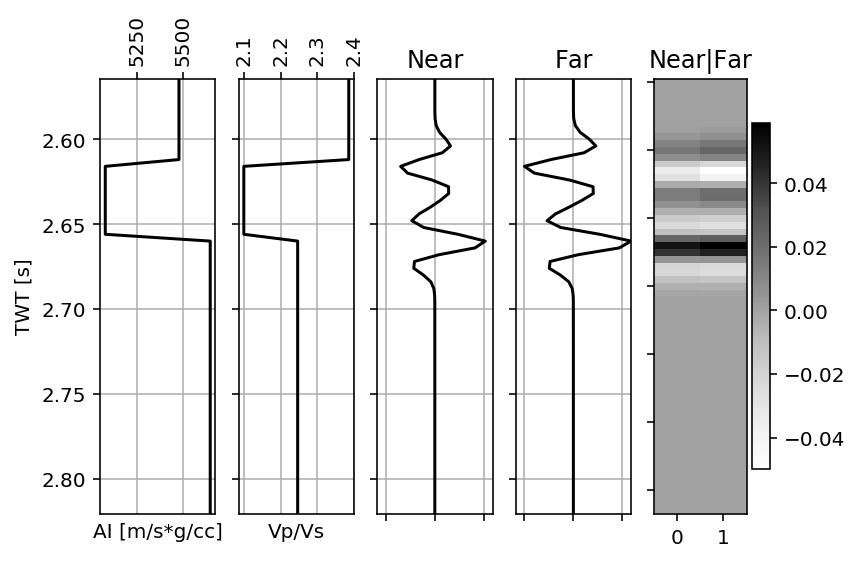

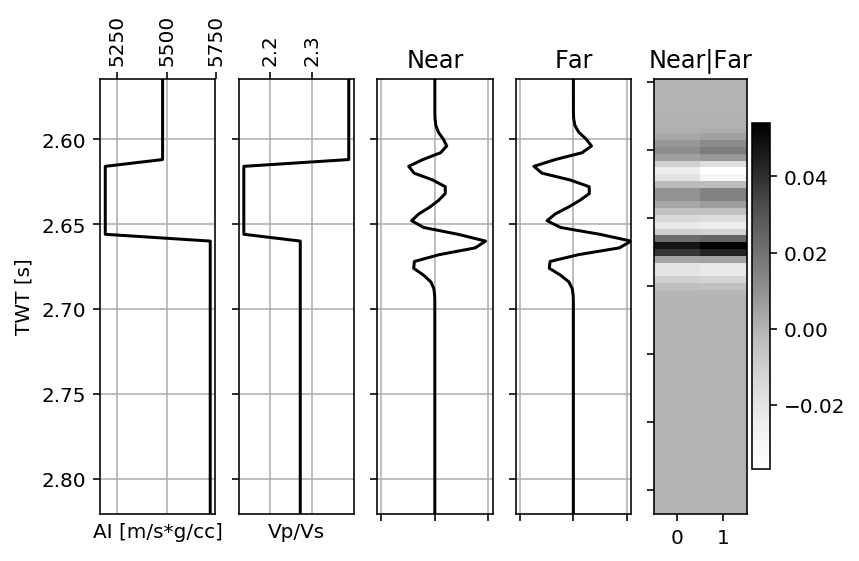

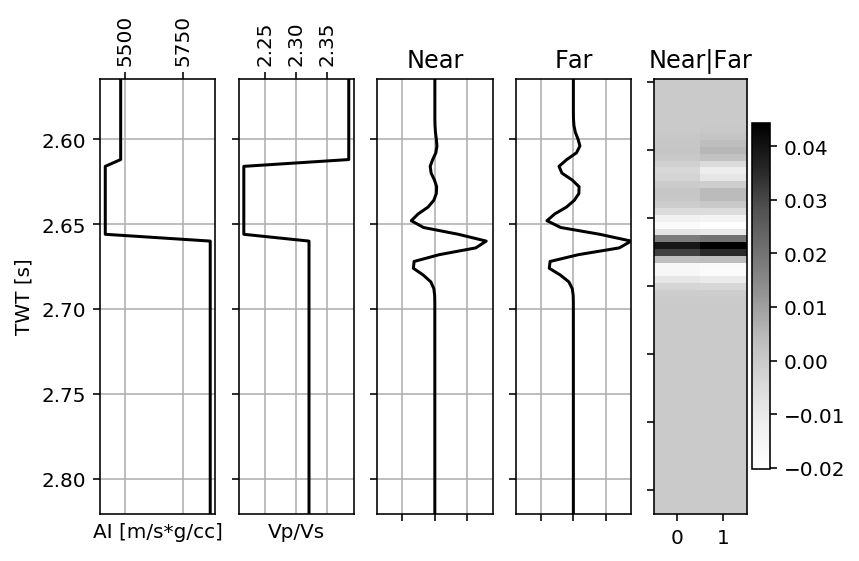

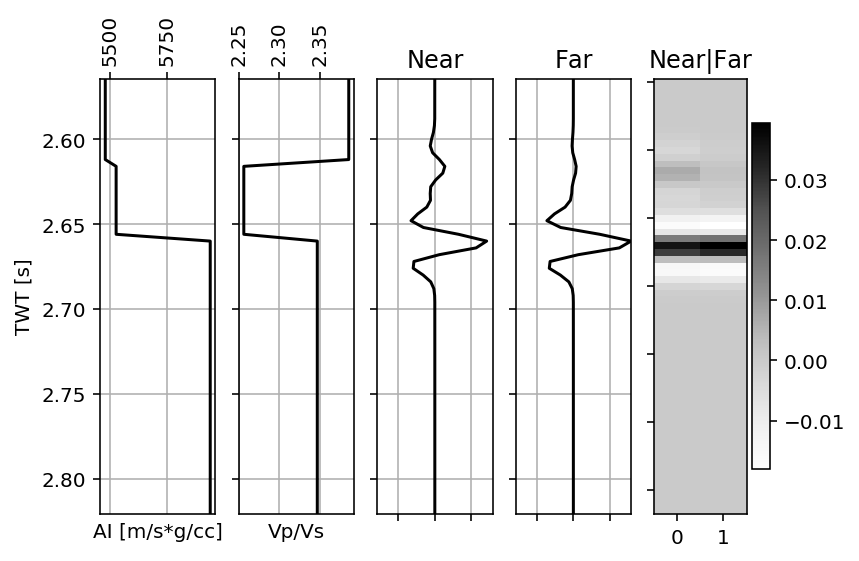

In [75]:
syntwells_dir='SYNTWELLS/'
test_files=[
'W155_5_Z60_Sw000_Por35',
'W155_5_Z60_Sw025_Por35',
'W155_5_Z60_Sw075_Por35',
'W155_5_Z60_Sw100_Por35']

for ff in test_files:
    nn=pd.read_csv(syntwells_dir+ff, usecols=[1,2,3,4], index_col=0)
    nnt,_,_ = hl.welltime(nn,tdr_w2,dt=dt,tops=tops_w2,qcplot=False)
    rc,synt=hl.make_synt(nnt,ang,wavl,method='aki')
    hl.plot_synt(nnt,synt,t1,t2,20)
#     plt.savefig('FIGS/{}_synth_variable_Sw.png'.format(names[i].replace('/','_')))

***

Reads back in the entire Pandas dataframe with the pseudowells near and far traces and plots them stacked side by side like if it was a seismic section:

Text(0.5,1,'15/5-5 Far')

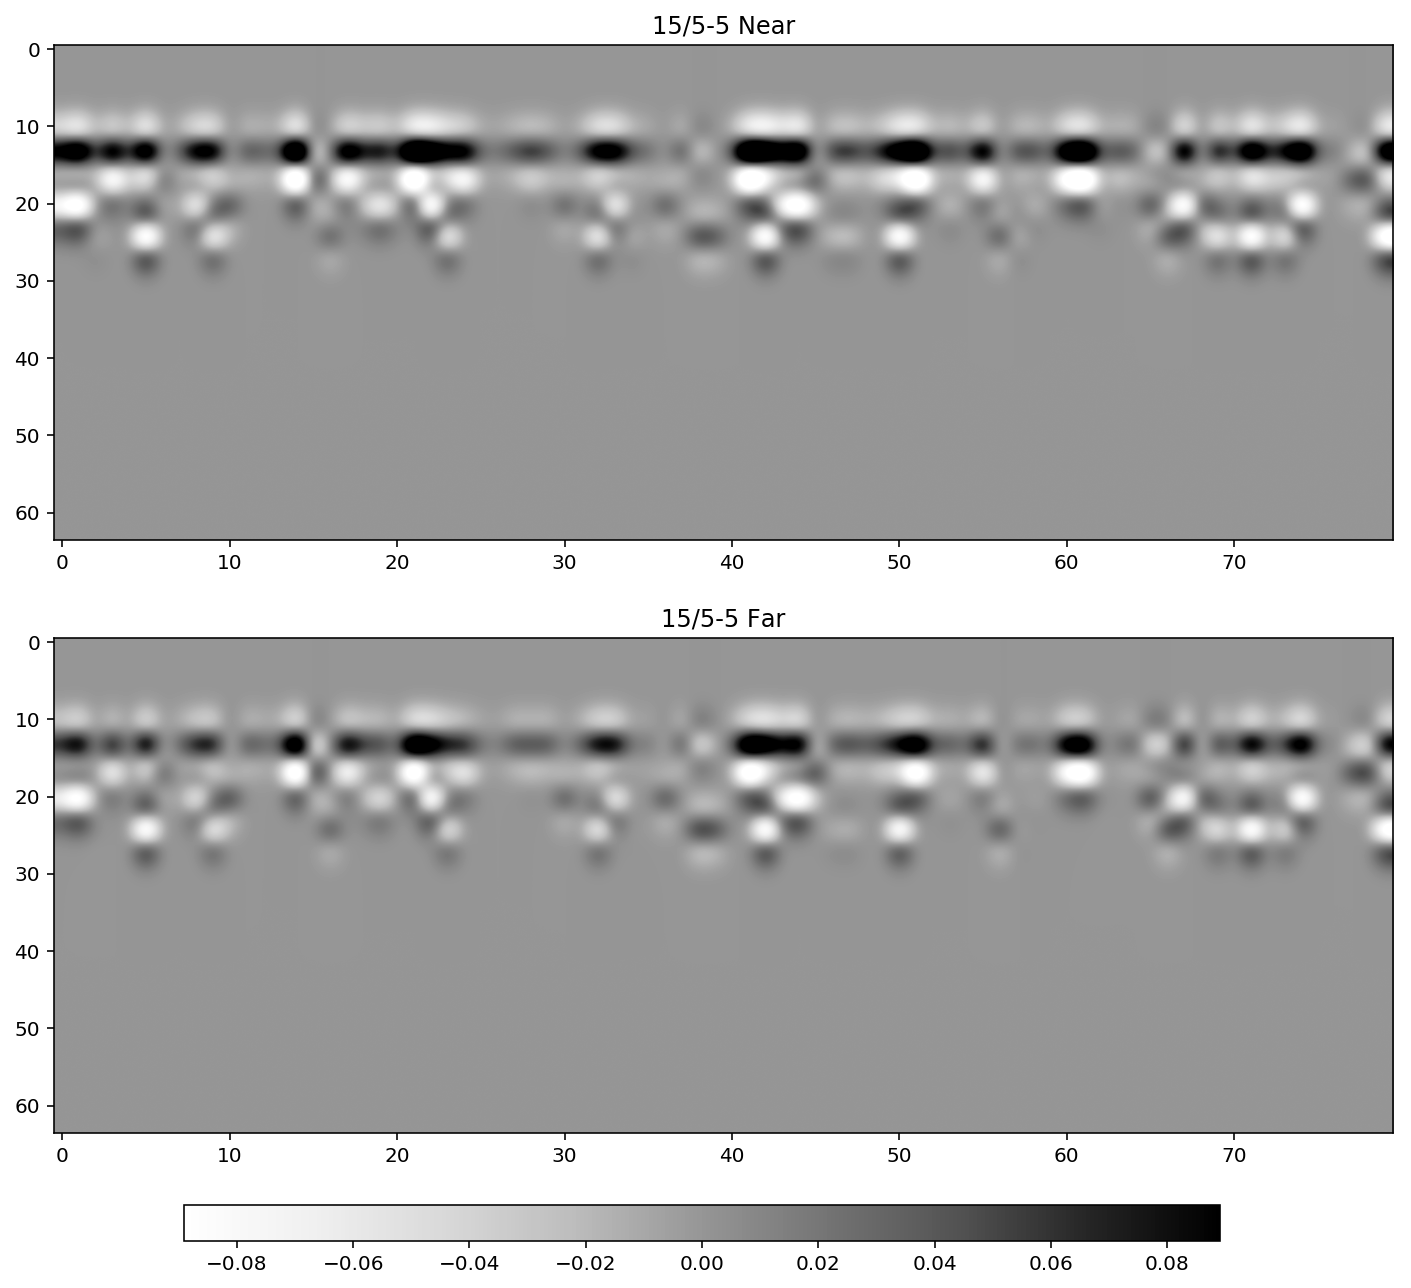

In [77]:
syntw2=pd.read_csv('syntdataset_W155_5.csv')
nears, fars = hl.get_nears_fars(syntw2)

clip=abs(np.percentile([nears,fars], 0.80))

f,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,10))
im0=ax[0].imshow(nears,cmap='Greys',vmax=clip,vmin=-clip,aspect='auto', interpolation='bicubic')
im1=ax[1].imshow(fars,cmap='Greys',vmax=clip,vmin=-clip,aspect='auto', interpolation='bicubic')
cax = f.add_axes([0.2, 0.05, 0.6, 0.025])
f.colorbar(im0, cax=cax, orientation='horizontal')
ax[0].set_title('15/5-5 Near')
ax[1].set_title('15/5-5 Far')
# plt.savefig('FIGS/{}_synth_variable_Sw.png'.format(uuu))

***

Reads traces reconstructed by Lukas' ML algorithm and display them side by side with input traces to show the "denoising" effect:

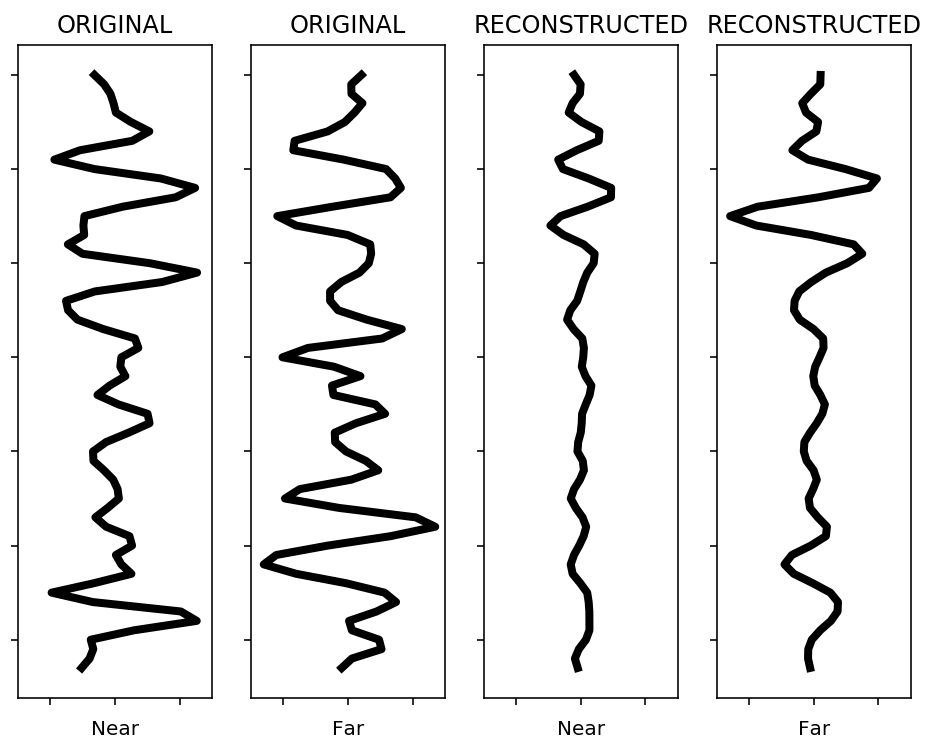

In [78]:
test_samples = np.load("test_out_49.npy")

opt={'linewidth':4, 'color':'black'}

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8, 6))
# real
ax[0].plot(test_samples[0,5,0,:], range(64), **opt) # near
ax[1].plot(test_samples[0,5,1,:], range(64), **opt) # far
# reconstructed
ax[2].plot(test_samples[1,5,0,:], range(64), **opt) # near
ax[3].plot(test_samples[1,5,1,:], range(64), **opt) # far
for aa in [ax[0],ax[2]]:
    aa.set_xlabel('Near')
for aa in [ax[1],ax[3]]:
    aa.set_xlabel('Far')
for aa in ax[:3]:
    aa.set_title('ORIGINAL')
for aa in ax[2:]:
    aa.set_title('RECONSTRUCTED')
for aa in ax:
    aa.set_yticklabels([])
    aa.set_xticklabels([])
    aa.invert_yaxis()
    aa.set_xlim(-3,3)
# plt.savefig('FIGS/original-reconstructed.png')

### references
    
* Avseth, P., Mukerji, T. & Mavko, G. Quantitative Seismic Interpretation. (Cambridge University Press, 2005).
    